In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.datasets as datasets
import torch.utils.data as data
import os
import torch

rng = np.random.default_rng()

In [2]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(pretrained=True)
model.eval()

# For Preprocessing the input images

preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

/home/ayush/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ayush/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
data_dir = 'tiny-224/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=preprocess) 
                  for x in ['train','test']}
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=8)
                  for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [5]:
TRAIN_SIZE = 100
TEST_SIZE = 10 * TRAIN_SIZE/100
trainset = []
testset = []
train_labels = []
test_labels = []
train_prediction = []
test_prediction = []
THRESHOLD = 0.001

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

for i, data in enumerate(dataloaders['train'], 0):
    with torch.no_grad():
        if i<TRAIN_SIZE:
            inputs, l  = data
            prediction = model(inputs).squeeze(0).softmax(0)

            img_unnormalized = inputs.squeeze(0).clone()
            for i in range(3):
                img_unnormalized[i] = img_unnormalized[i] * std[i] + mean[i]
            trainset.append(img_unnormalized.permute(1,2,0).detach().numpy())

            class_id = prediction.argmax().item()
            score = prediction[class_id].item()
            category_name = weights.meta["categories"][class_id]
            train_labels.append(f"{category_name}: {100 * score:.1f}%")

            pred = prediction.detach().numpy()
            pred[pred < THRESHOLD] = 0
            train_prediction.append(pred)
        else:
            break

In [6]:
for i, data in enumerate(dataloaders['test'], 0):
    with torch.no_grad():
        if i<TEST_SIZE:
            inputs, l  = data
            prediction = model(inputs).squeeze(0).softmax(0)

            img_unnormalized = inputs.squeeze(0).clone()
            for i in range(3):
                img_unnormalized[i] = img_unnormalized[i] * std[i] + mean[i]
            testset.append(img_unnormalized.permute(1,2,0).detach().numpy())

            class_id = prediction.argmax().item()
            score = prediction[class_id].item()
            category_name = weights.meta["categories"][class_id]
            test_labels.append(f"{category_name}: {100 * score:.1f}%")

            pred = prediction.detach().numpy()
            pred[pred < THRESHOLD] = 0
            test_prediction.append(pred)
        else:
            break

(100, 1000)
(100, 224, 224, 3)
(10, 1000)
(10, 224, 224, 3)


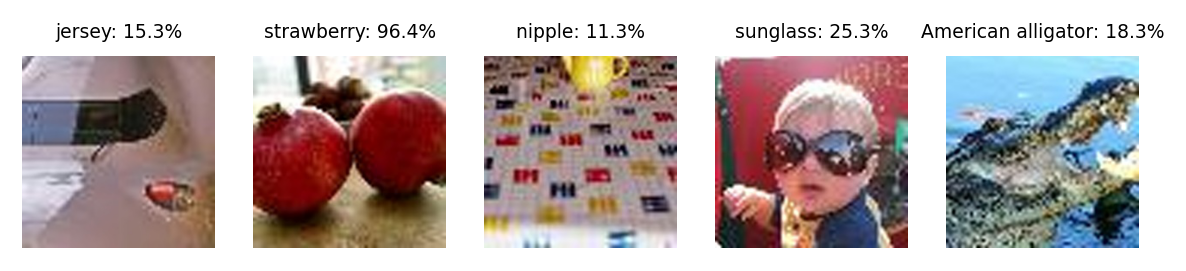

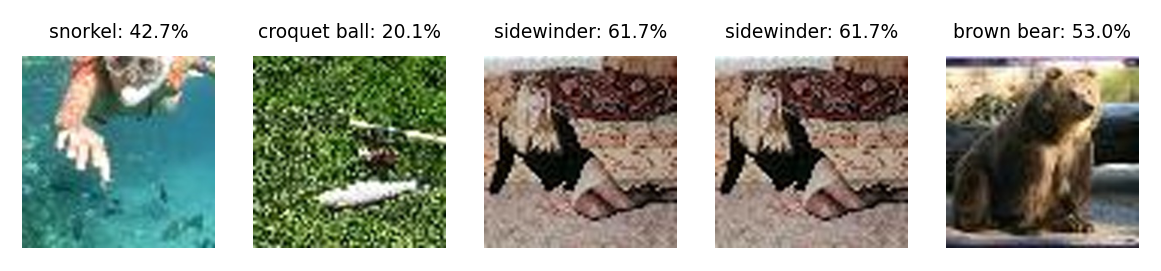

In [7]:
train_prediction = np.array(train_prediction)
print(train_prediction.shape)

trainset = np.array(trainset)
print(trainset.shape)

test_prediction = np.array(test_prediction)
print(test_prediction.shape)

testset = np.array(testset)
print(testset.shape)


f, axarr = plt.subplots(1, 5)
f.dpi = 225

index = rng.integers(low=0, high=TRAIN_SIZE, size=5)
for i in range(5):
    axarr[i].set_title(train_labels[index[i]], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(trainset[index[i]])

plt.show()



f, axarr = plt.subplots(1, 5)
f.dpi = 225

index = rng.integers(low=0, high=TEST_SIZE, size=5)
for i in range(5):
    axarr[i].set_title(test_labels[index[i]], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(testset[index[i]])

plt.show()